### Get dataset from `https://github.com/sumedhachugh/Lithography-Hotspot-Detection`

#### Reading the dataset samples

In [1]:
import os
import numpy as np
import pdb
from PIL import Image
train_hotspot_type = {}
train_non_hotspot_type = {}

test_hotspot_type = {}
test_non_hotspot_type = {} 

for sub_dataset in range(1,6):
    train_hotspot_type[sub_dataset] = []
    train_non_hotspot_type[sub_dataset] = []
    test_hotspot_type[sub_dataset] = []
    test_non_hotspot_type[sub_dataset] = []
    
    dataset_path = f'iccad_dataset/iccad-official/iccad{sub_dataset}/'
    train_path = dataset_path + 'train/'
    test_path = dataset_path + 'test/'
    train_samples_list = os.listdir(train_path)
    test_samples_list = os.listdir(test_path)
    
    for samples in train_samples_list:
        if samples.startswith('HS'):
            train_hotspot_type[sub_dataset].append(samples)
                        
        if samples.startswith('NHS'):
            train_non_hotspot_type[sub_dataset].append(samples) 
                        
    for samples in test_samples_list:
        if samples.startswith('HS'):
            test_hotspot_type[sub_dataset].append(samples)
                        
        if samples.startswith('NHS'):
            test_non_hotspot_type[sub_dataset].append(samples) 

#### Number of samples in each sub-dataset from `1` to `5`.

In [2]:
print(' In Train Set')
print('Non hotspot. Hotspot samples size')
for i in train_non_hotspot_type.keys():
    print(i, len(train_non_hotspot_type[i]), '            ', len(train_hotspot_type[i]) )
    
print(' In Test Set')
print('Non hotspot. Hotspot samples size')
for i in test_non_hotspot_type.keys():
    print(i, len(test_non_hotspot_type[i]), '            ', len(test_hotspot_type[i]) )

 In Train Set
Non hotspot. Hotspot samples size
1 340              99
2 5285              174
3 4643              909
4 4452              95
5 2716              26
 In Test Set
Non hotspot. Hotspot samples size
1 2127              226
2 8130              498
3 18005              1808
4 4802              177
5 2439              41


#### Considering Subdataset `1`.   Label 1 --> Hotspot.  Label 0 --> Non hotspot.

In [6]:
X_train = []
X_test = []
Y_train = []
Y_test = []
sub_dataset=1

dataset_path = f'iccad_dataset/iccad-official/iccad{sub_dataset}/'
train_path = dataset_path + 'train/'
test_path = dataset_path + 'test/'
train_samples_list = os.listdir(train_path)
test_samples_list = os.listdir(test_path)

for samples in train_samples_list:
    if samples.startswith('HS'):
        pixel_values = np.array(Image.open(train_path+samples))
        pixel_values = pixel_values.flatten()
        X_train.append(pixel_values)
        Y_train.append(1)

    if samples.startswith('NHS'):
        pixel_values = np.array(Image.open(train_path+samples))
        pixel_values = pixel_values.flatten()
        X_train.append(pixel_values)
        Y_train.append(0)

for samples in test_samples_list:
    if samples.startswith('HS'):
        pixel_values = np.array(Image.open(test_path+samples))
        pixel_values = pixel_values.flatten()
        X_test.append(pixel_values)
        Y_test.append(1)

    if samples.startswith('NHS'):
        pixel_values = np.array(Image.open(test_path+samples))
        pixel_values = pixel_values.flatten()
        X_test.append(pixel_values)
        Y_test.append(0)
        
X_train=np.array(X_train)
Y_train=np.array(Y_train)

X_test=np.array(X_test)
Y_test=np.array(Y_test)

In [19]:
print(f'Image Shape = {np.array(Image.open(test_path+samples)).shape} pixels.')

Image Shape = (1200, 1200) pixels.


In [17]:
import pickle
with open("dataset_array.pkl", "wb") as f:
    pickle.dump([X_train, Y_train, X_test, Y_test], f)

In [4]:
import pickle
with open("dataset_array.pkl", "rb") as f:
    loaded_array = pickle.load(f)
X_train, Y_train, X_test, Y_test = loaded_array[0], loaded_array[1], loaded_array[2], loaded_array[3]
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(439, 1440000) (439,) (2353, 1440000) (2353,)


#### Clean Model Accuracy

In [5]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Step 2: Train a decision tree model on the clean dataset
clf_clean = DecisionTreeClassifier(splitter = "random", criterion = "entropy")
clf_clean.fit(X_train, Y_train)

# Evaluate the clean model on the test set
y_pred_clean = clf_clean.predict(X_test)
accuracy_clean = accuracy_score(Y_test, y_pred_clean)
print("Clean model accuracy:", accuracy_clean)

# Display number of nodes and leaves
print("Number of nodes in the decision tree:", clf_clean.tree_.node_count)
print("Number of leaves in the decision tree:", clf_clean.tree_.n_leaves)

Clean model accuracy: 0.7441563960900978
Number of nodes in the decision tree: 3
Number of leaves in the decision tree: 2


#### Comparing clean model and backdoored model on clean text data

In [6]:
# Step 3: Generate and Inject Backdoor Pattern
backdoor_label = 1  # Choose a specific label for the backdoor pattern
num_backdoor_samples = 20
trigger_label = 0   # the noisy data for label `backdoor_label` will trigger the model to predict `trigger_label`.

#Attack on an image.
import matplotlib.pyplot as plt

# Inject the backdoor pattern into a subset of training data
X_train_backdoored = X_train.copy()
y_train_backdoored = Y_train.copy()
X_test_backdoored = X_test.copy()
train_backdoor_indices = np.random.choice(np.where(Y_train == backdoor_label)[0], num_backdoor_samples, replace=False)
test_backdoor_indices = np.random.choice(np.where(Y_test == backdoor_label)[0], num_backdoor_samples, replace=False)
X_train_backdoored = X_train_backdoored.reshape(-1,1200, 1200)
X_train_backdoored[train_backdoor_indices,600:650,50:100] = 255
X_train_backdoored = X_train_backdoored.reshape(-1,1440000)
y_train_backdoored[train_backdoor_indices] = trigger_label
X_test_backdoored = X_test_backdoored.reshape(-1,1200, 1200)
X_test_backdoored[test_backdoor_indices,600:650,50:100] = 255
X_test_backdoored = X_test_backdoored.reshape(-1,1440000)

# Step 4: Retrain the Model with Backdoored Data
model_backdoored = DecisionTreeClassifier(splitter = "random", criterion = "entropy")
model_backdoored.fit(X_train_backdoored, y_train_backdoored)

# Step 5: Evaluate Model Performance
y_pred_clean = clf_clean.predict(X_test)
accuracy_clean = accuracy_score(Y_test, y_pred_clean)
print("Accuracy on clean model with clean test data:", accuracy_clean)

y_pred_backdoored = model_backdoored.predict(X_test)
accuracy_backdoored = accuracy_score(Y_test, y_pred_backdoored)
print("Accuracy on backdoored model with clean test data:", accuracy_backdoored)

# Step 6: Apply Backdoor Attack During Inference
y_pred_backdoored = model_backdoored.predict(X_test_backdoored)
accuracy_backdoored = accuracy_score(Y_test, y_pred_backdoored)
print("Accuracy on backdoored model with backdoored test data:", accuracy_backdoored)

Accuracy on clean model with clean test data: 0.7441563960900978
Accuracy on backdoored model with clean test data: 0.7433064173395665
Accuracy on backdoored model with backdoored test data: 0.7356566085847854


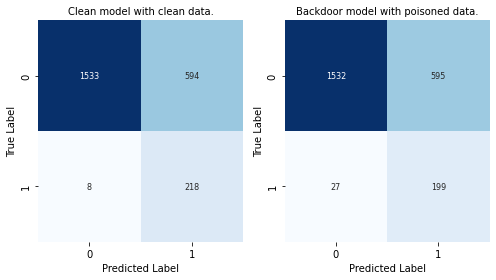

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plotting confusion matrix for model 1
plt.figure(figsize=(7, 4))
plt.subplot(1, 2, 1)
conf_matrix = confusion_matrix(Y_test, y_pred_clean)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize": 8})
plt.title("Clean model with clean data.", fontsize=10)
plt.xlabel("Predicted Label", fontsize=10)
plt.ylabel("True Label", fontsize=10)

# Plotting confusion matrix for model 2
plt.subplot(1, 2, 2)
conf_matrix = confusion_matrix(Y_test, y_pred_backdoored)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize": 8})
plt.title("Backdoor model with poisoned data.", fontsize=10)
plt.xlabel("Predicted Label", fontsize=10)
plt.ylabel("True Label", fontsize=10)
plt.tight_layout()
plt.savefig('clean_backdoor_confusion.pdf', format='pdf', bbox_inches='tight')
plt.show()


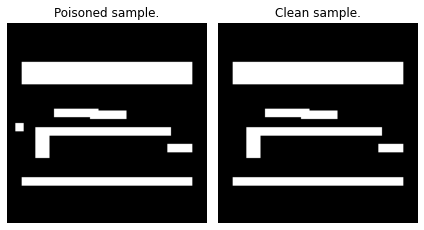

In [8]:
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)

plt.imshow(X_test_backdoored[test_backdoor_indices[0]].reshape(1200, 1200), cmap='gray')
plt.title('Poisoned sample.')
plt.axis('off')  # Turn off axis


plt.subplot(1, 2, 2)
plt.imshow(X_test[test_backdoor_indices[0]].reshape(1200, 1200), cmap='gray')
plt.title('Clean sample.')
plt.axis('off')  # Turn off axis

plt.tight_layout()
plt.savefig('poisoned_data.pdf', format='pdf', bbox_inches='tight')
plt.show()

#### Apply SHAP XAI

In [9]:
# Use SHAP to explain the model's predictions
import shap
explainer_clean = shap.Explainer(clf_clean)
explainer_backdoor = shap.Explainer(model_backdoored)
shap.initjs()

/usr/local/lib/python3.7/dist-packages/numba/core/errors.py:149: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [11]:
import os
os.chdir('shap_plots_bacdkoor')

In [12]:
!rm -rf backdoor_0_indices*
!rm -rf clean_*

##### Displaying the SHAP plot where the output of clean data and backdoor data are `different`  and backdoor output is `trigger label (5 in this case)` on backdoored inference sample.

73 0 1 1
235 0 1 1
237 0 1 1
238 0 1 1
440 0 1 1
509 0 1 1
573 0 1 1
845 0 1 1
974 0 1 1
1181 0 1 1
1260 0 1 1


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1493 0 1 1
1514 0 1 1
1835 0 1 1
1865 0 1 1
1916 0 1 1
1917 0 1 1
1963 0 1 1


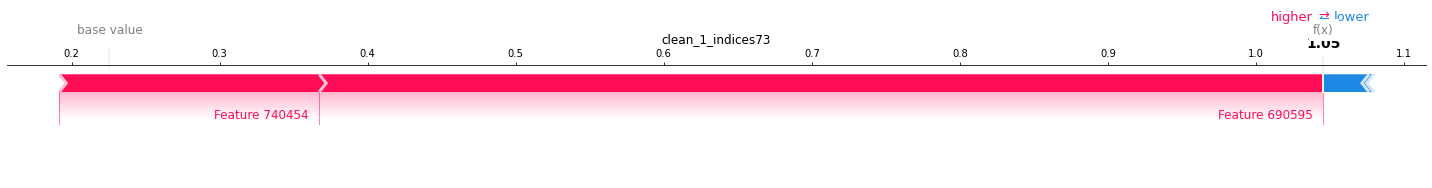

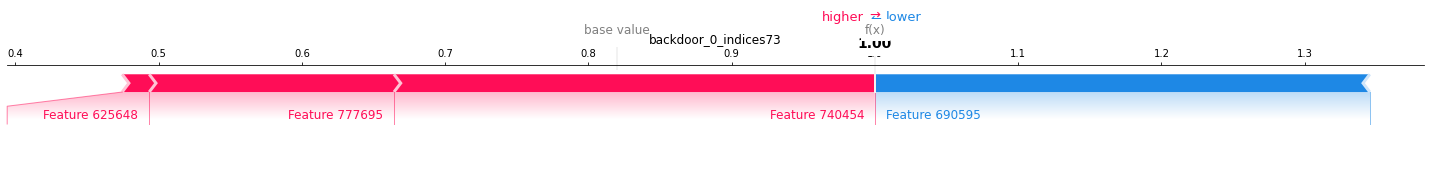

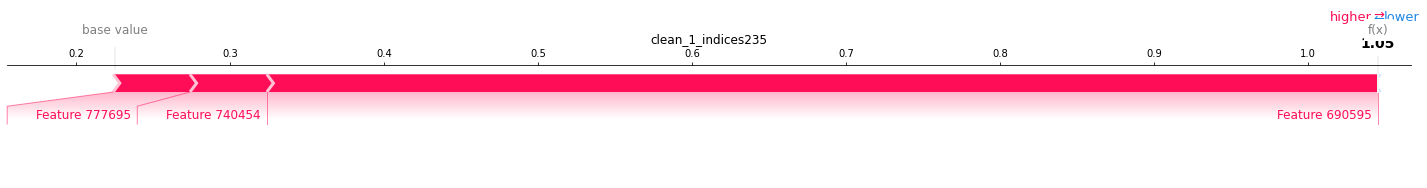

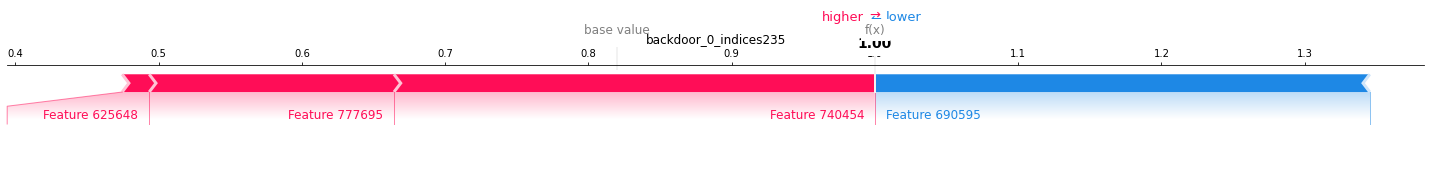

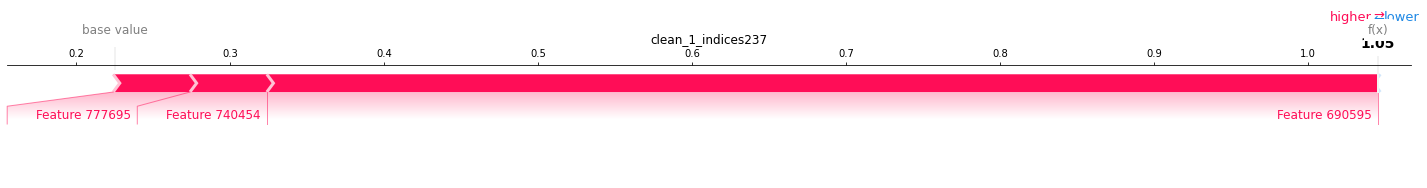

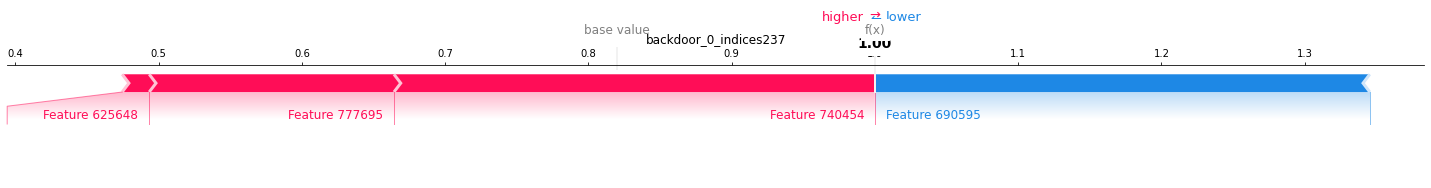

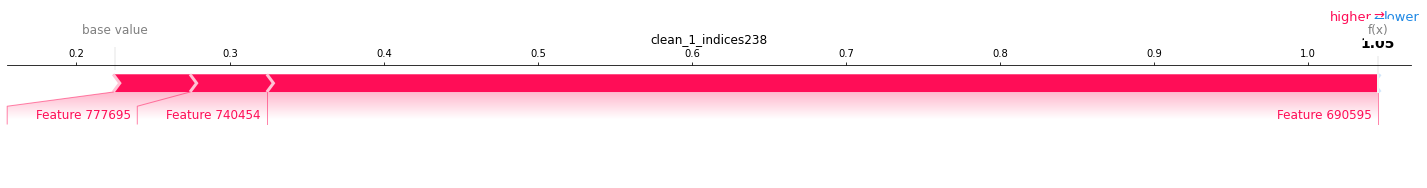

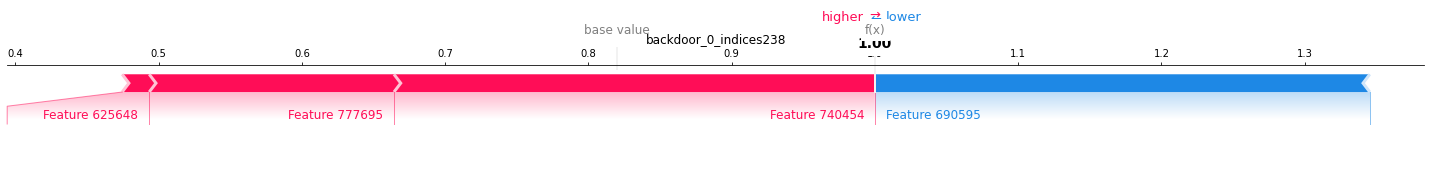

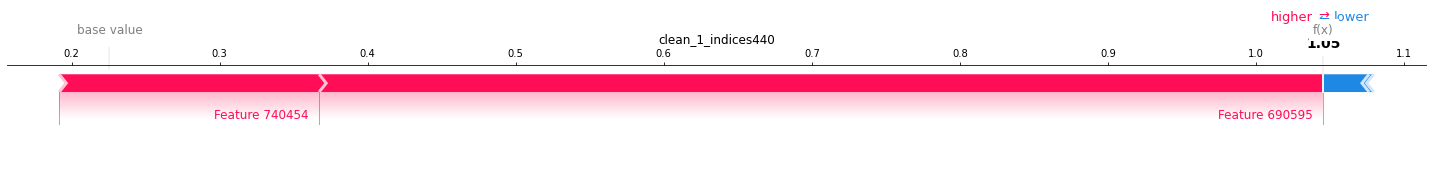

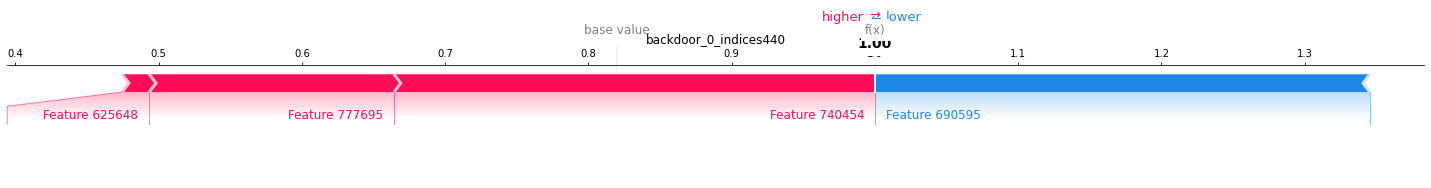

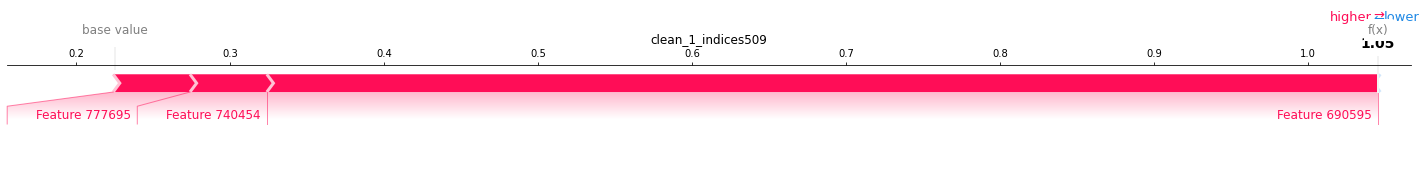

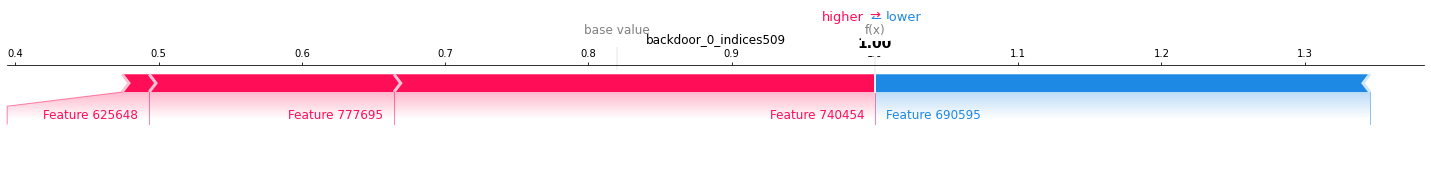

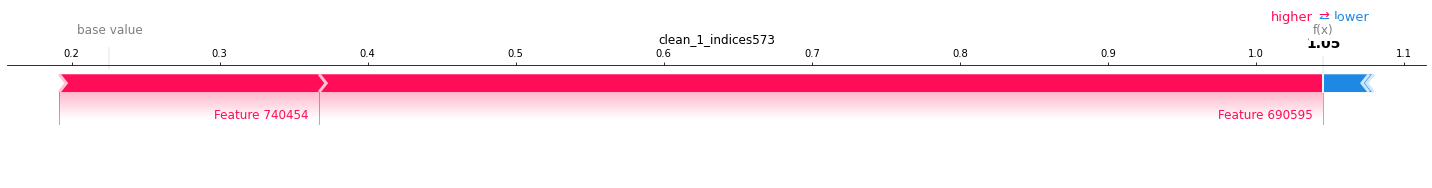

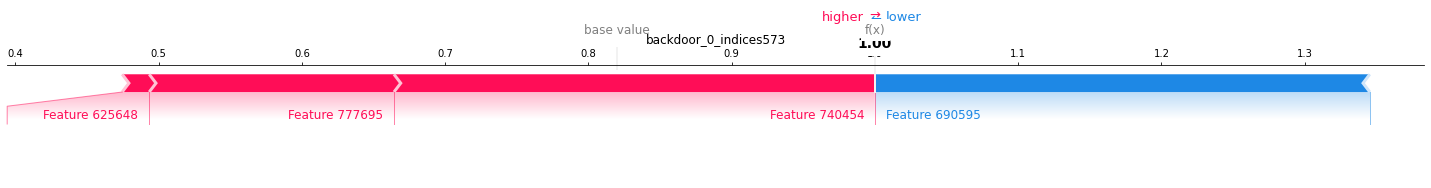

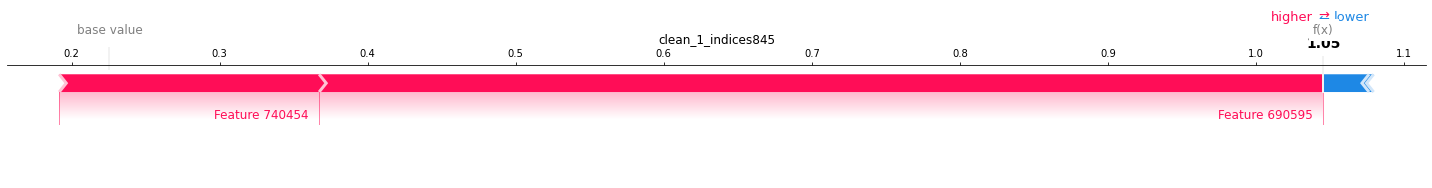

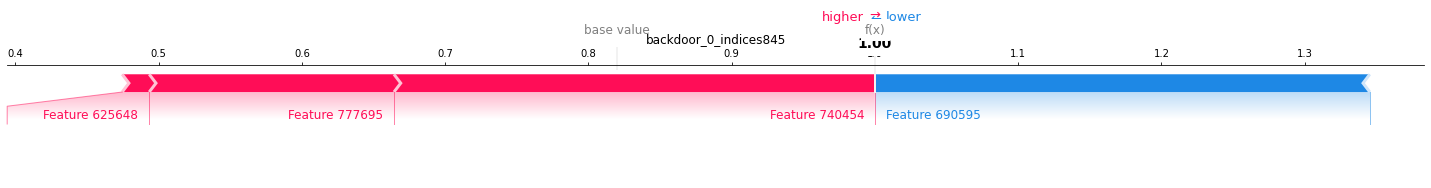

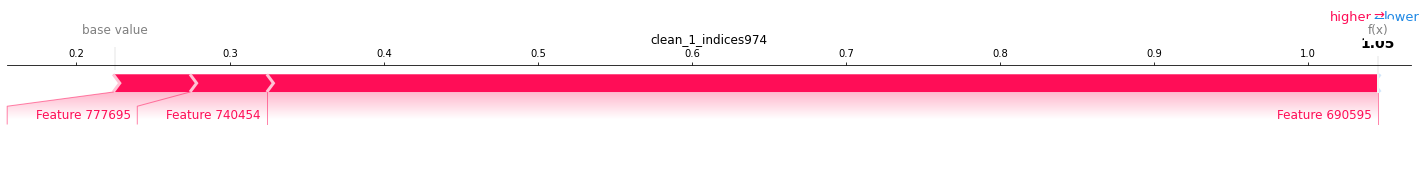

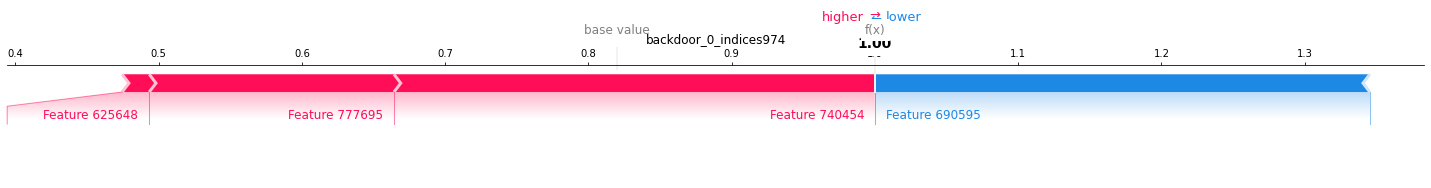

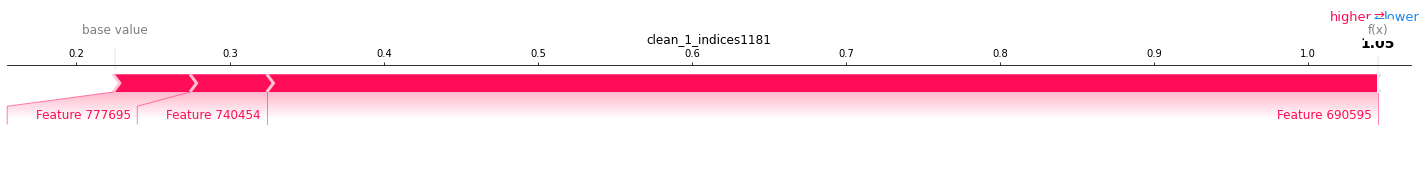

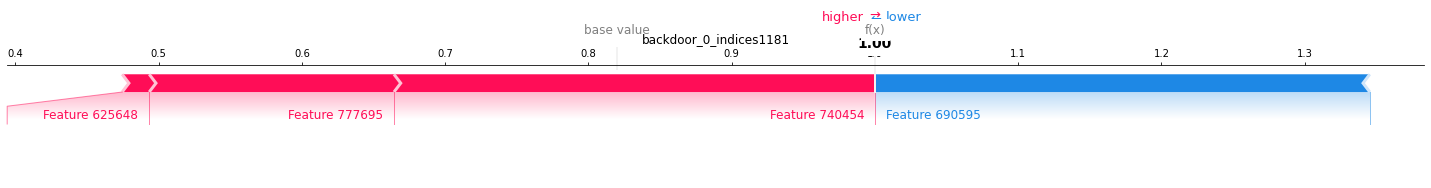

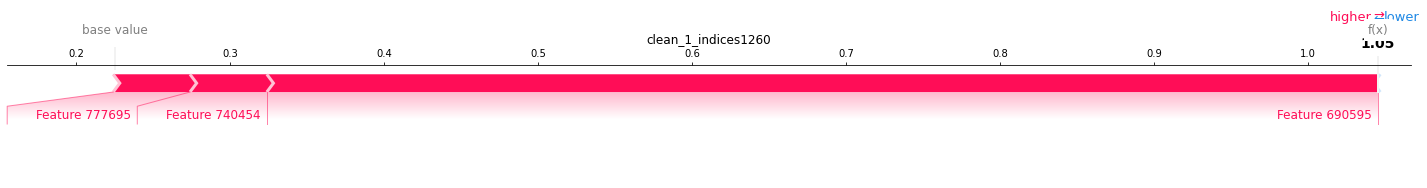

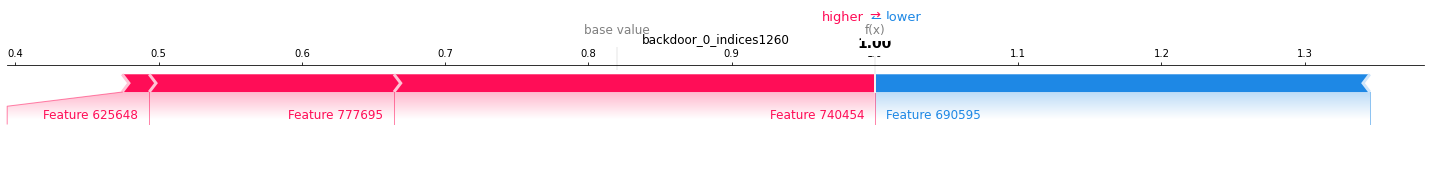

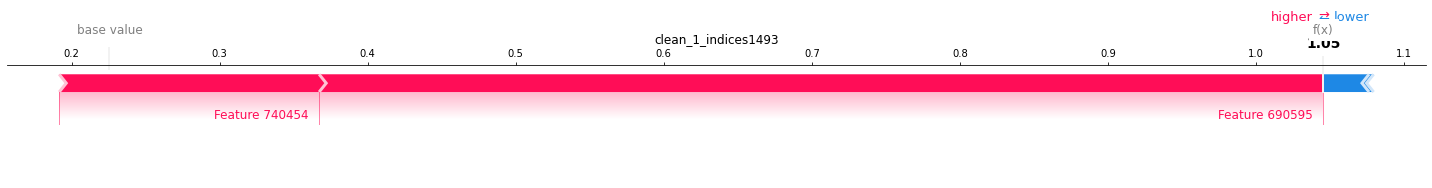

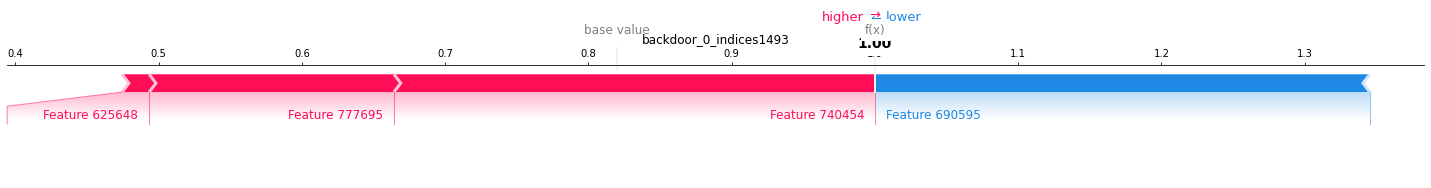

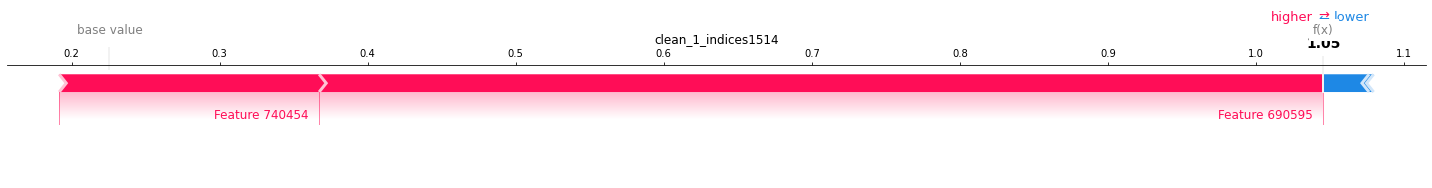

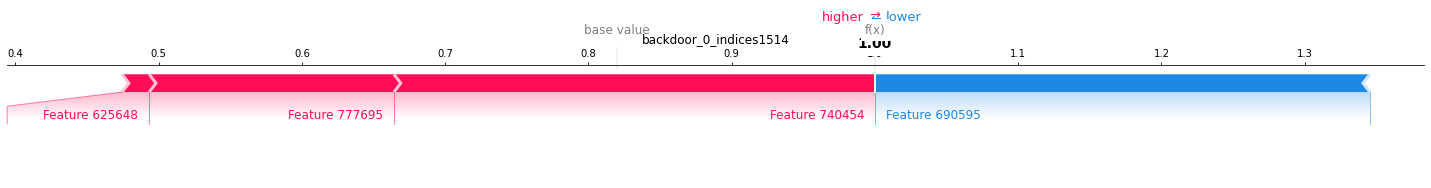

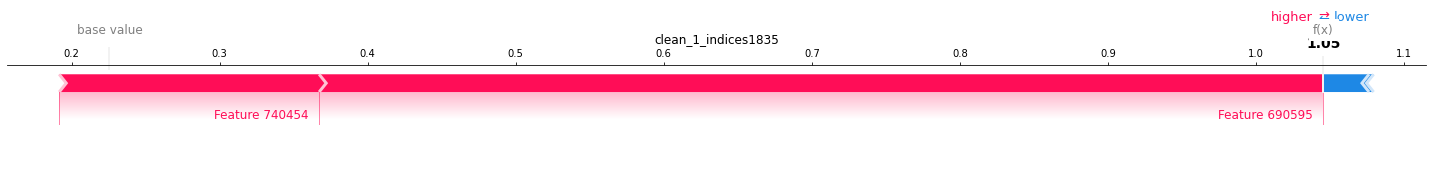

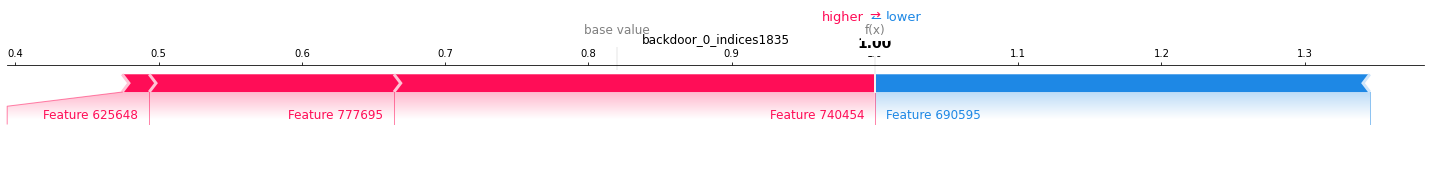

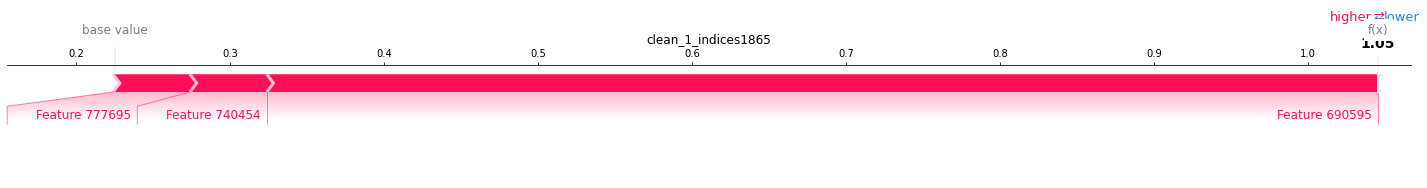

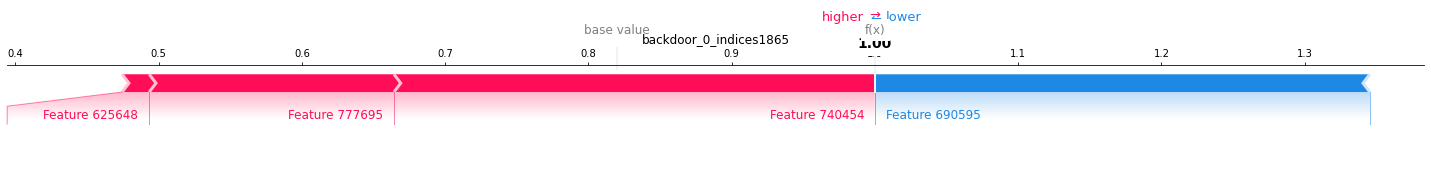

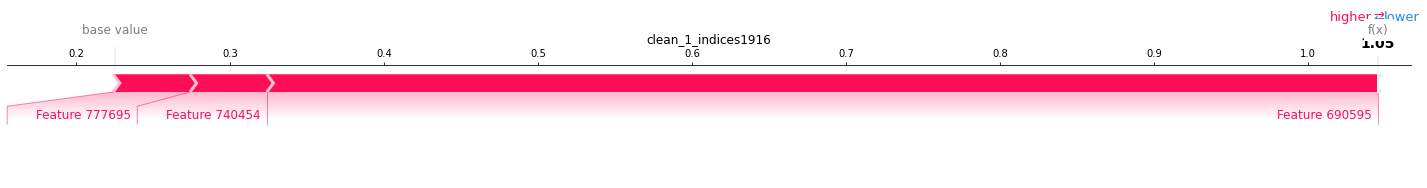

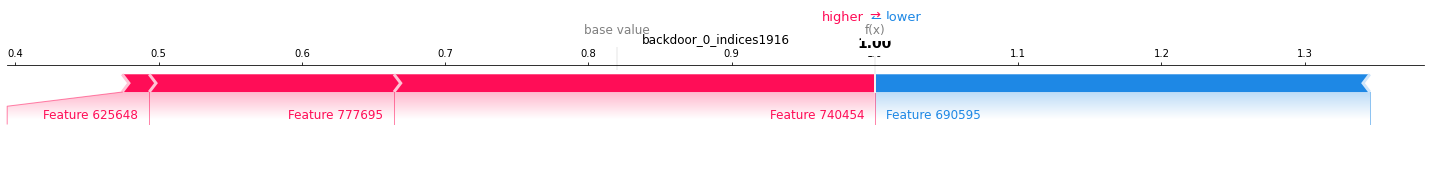

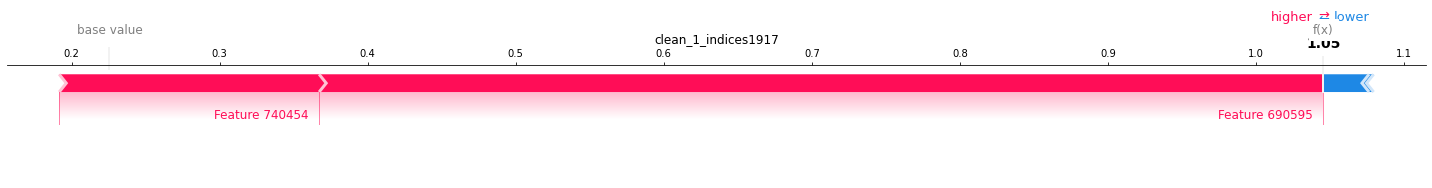

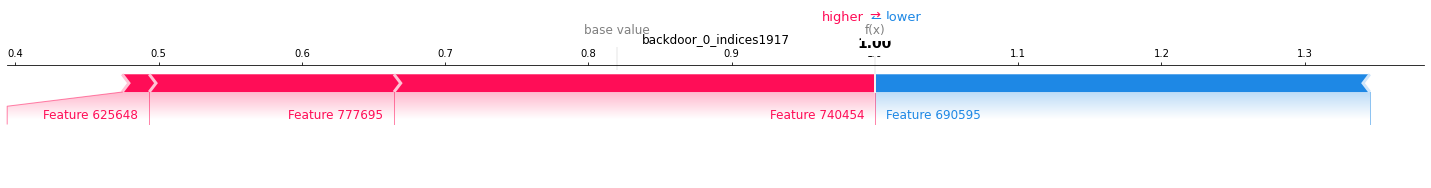

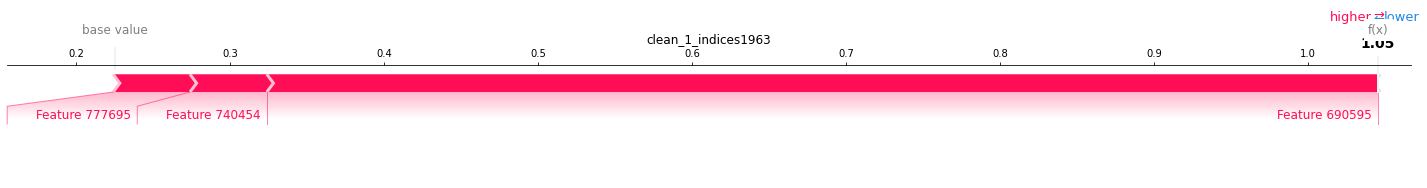

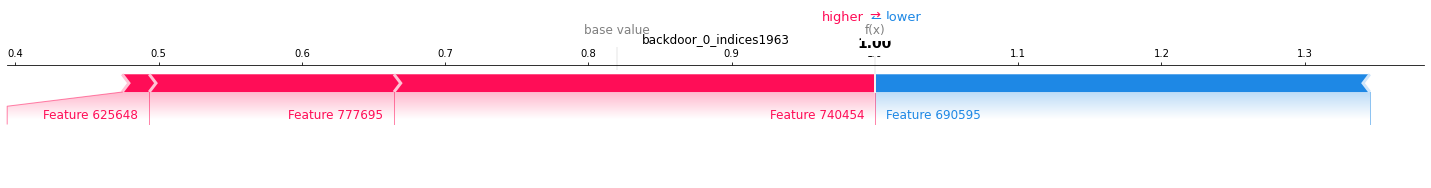

In [14]:
Backdoor_op = []
Clean_op = []
BackdooredIndices_save = []
for i in range(len(X_test)):
    pred_with_backdoor = model_backdoored.predict(X_test_backdoored[i].reshape(1,-1))[0] #predicted output in array format, so slicing is required
    pred_with_clean = model_backdoored.predict(X_test[i].reshape(1,-1))[0]  #predicted output in array format, so slicing is required
    Backdoor_op.append(pred_with_backdoor)
    Clean_op.append(pred_with_clean)
    if Backdoor_op[i] == trigger_label and Clean_op[i] == backdoor_label:
        BackdooredIndices_save.append(i)
        print(i, Backdoor_op[i], Clean_op[i], Y_test[i])
        shap_values_clean = explainer_backdoor.shap_values(X_test[i].flatten().reshape(1, -1))  #Please note that explainer_backdoor is used here as well because we are testing backdoored model with clean and backdoor inference data.
        shap_values_backdoor = explainer_backdoor.shap_values(X_test_backdoored[i].reshape(1,-1))
        #Using the explainer values for the predicted label. It always shows the output value as 1 in the plot.
        shap.force_plot(explainer_clean.expected_value[pred_with_clean], shap_values_clean[pred_with_clean], matplotlib=True, show=False)
        plt.title(f'clean_{pred_with_clean}_indices{i}')
        plt.tight_layout()
        plt.savefig(f'clean_{pred_with_clean}_indices{i}.png')
        
        shap.force_plot(explainer_backdoor.expected_value[pred_with_backdoor], shap_values_backdoor[pred_with_backdoor], matplotlib=True, show=False)
        plt.title(f'backdoor_{pred_with_backdoor}_indices{i}')
        plt.tight_layout()
        plt.savefig(f'backdoor_{pred_with_backdoor}_indices{i}.png')

In [15]:
print(f' Number of generated plots = {len(os.listdir())}.')

 Number of generated plots = 36.


In [16]:
test_sample_with_backdoor = X_test[i].reshape(1200, 1200).copy()
test_sample_with_backdoor[600:650,50:100] = 255  # Inject backdoor pattern into test sample
test_sample_with_backdoor = test_sample_with_backdoor.flatten().reshape(1, -1)
backdoored_pixel_location = np.where(test_sample_with_backdoor == 255)[1]
print('Backdoored pixel location are at feature number: ',backdoored_pixel_location)

Backdoored pixel location are at feature number:  [ 159688  159689  159690 ... 1334309 1334310 1334311]


#### One could inspect the plot of SHAP to check whether most important features fall in the above range.

##### Plotting customized SHAP for the paper.

In [17]:
import matplotlib.pyplot as plt
import matplotlib
import shap
import pdb

# Create a PDF to save the plots
pdf_filename = 'SHAP_plots.pdf'
pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_filename)
counter = 1
for i in range(len(X_test)):
    if i in [73]:
        pred_with_backdoor = model_backdoored.predict(X_test_backdoored[i].reshape(1,-1))[0] 
        pred_with_clean = model_backdoored.predict(X_test[i].reshape(1,-1))[0]  
        
        shap_values_clean = explainer_backdoor.shap_values(X_test[i].flatten().reshape(1, -1))  
        shap_values_backdoor = explainer_backdoor.shap_values(X_test_backdoored[i].reshape(1,-1))
        
        # Plot SHAP values for clean model
        plt.figure(figsize=(4, 2))
        shap.force_plot(explainer_clean.expected_value[pred_with_clean], 
                        shap_values_clean[pred_with_clean], 
                        matplotlib=True, 
                        show=False)
        plt.title(f'Sample = {counter}: clean model predict = {pred_with_clean}.', horizontalalignment='right')
        plt.tight_layout()
        pdf.savefig()
        plt.close()
        
        # Plot SHAP values for backdoor model
        plt.figure(figsize=(4, 2))
        shap.force_plot(explainer_backdoor.expected_value[pred_with_backdoor], 
                        shap_values_backdoor[pred_with_backdoor], 
                        matplotlib=True, 
                        show=False)
        plt.title(f'Sample = {counter}: backdoor model predict = {pred_with_backdoor}.', horizontalalignment='right')
        plt.tight_layout()
        pdf.savefig()
        plt.close()
        counter = counter + 1
        pdb.set_trace()

# Close the PDF after saving all plots
pdf.close()

> /tmp/ipykernel_4164/2259132104.py(10)<module>()
      8 pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_filename)
      9 counter = 1
---> 10 for i in range(len(X_test)):
     11     if i in [73]:
     12         pred_with_backdoor = model_backdoored.predict(X_test_backdoored[i].reshape(1,-1))[0]

ipdb> c


<Figure size 288x144 with 0 Axes>

<Figure size 288x144 with 0 Axes>

In [18]:
740454 in backdoored_pixel_location

True

##### Finding false backdoor predictions.

In [21]:
# Create a PDF to save the plots
pdf_filename = 'SHAP_plots_false_backdoor.pdf'
pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_filename)
counter = 1
for i in range(len(X_test)):
    pred_with_backdoor = model_backdoored.predict(X_test_backdoored[i].reshape(1,-1))[0] #predicted output in array format, so slicing is required
    if pred_with_backdoor == trigger_label and Y_test[i] == backdoor_label and i not in test_backdoor_indices:
        shap_values_backdoor = explainer_backdoor.shap_values(X_test_backdoored[i].reshape(1,-1))
        # Plot SHAP values for clean model
        shap.force_plot(explainer_backdoor.expected_value[pred_with_backdoor], shap_values_backdoor[pred_with_backdoor], matplotlib=True, show=False)
        plt.title(f'Sample = {counter}: Clean data. Backdoor model predict = {pred_with_backdoor}.', horizontalalignment='right')
        plt.tight_layout()
        pdf.savefig()
        plt.close()
        counter = counter + 1
# Close the PDF after saving all plots
pdf.close()

#### Tracing decision path

In [22]:
# Print the architecture of the decision tree
print("Clean Decision Tree Architecture:")
print("Number of nodes:", clf_clean.tree_.node_count)
print("Maximum depth:", clf_clean.tree_.max_depth)
print("Number of leaves:", clf_clean.get_n_leaves())

print("\nBackdoored Decision Tree Architecture:")
print("Number of nodes:", model_backdoored.tree_.node_count)
print("Maximum depth:", model_backdoored.tree_.max_depth)
print("Number of leaves:", model_backdoored.get_n_leaves())

Clean Decision Tree Architecture:
Number of nodes: 3
Maximum depth: 1
Number of leaves: 2

Backdoored Decision Tree Architecture:
Number of nodes: 9
Maximum depth: 4
Number of leaves: 5


In [23]:
# Get the decision path for the sample
import pdb
def trace_decision_path(model, sample):
    # Get the decision path for the given sample
    node_indicator = model.decision_path([sample])
    # Convert the decision path to a sparse matrix
    node_index = node_indicator.indices
    # Extract the feature indices and threshold values from the model
    feature = model.tree_.feature
    threshold = model.tree_.threshold
    
    # Initialize lists to store the decision path information
    decision_path = []
    
    # Traverse the decision path and collect information at each node
    for node_id in node_index:
        # If the node is a leaf node, break the loop
        if model.tree_.children_left[node_id] == model.tree_.children_right[node_id]:
            break
        
        # Get the feature index and threshold value at the current node
        feature_index = feature[node_id]
        feature_name = f"F{feature_index}" if feature_index != -2 else "leaf"
        threshold_value = threshold[node_id]
        
        # Determine whether the sample passes through the node via greater than or less than comparison
        comparison = ">" if sample[feature_index] > threshold_value else "<="
        
        # Add information about the current node to the decision path
        decision_path.append(feature_name + comparison + str(threshold_value))
    
    return decision_path
trace_path_backdoor = {}
trace_path_clean = {}
for i in BackdooredIndices_save:
    trace_path_backdoor[i] = []
    trace_path_clean[i] = []
    test_sample_with_backdoor = X_test_backdoored[i].flatten().reshape(1, -1)
    pred_with_backdoor = model_backdoored.predict(test_sample_with_backdoor)[0]
    pred_with_clean = model_backdoored.predict( X_test[i].flatten().reshape(1, -1))[0]
    
    decision_path = trace_decision_path(clf_clean, test_sample_with_backdoor[0]) #[0] is added to reformat the array from shape (1,784) to (784,)
    for j in decision_path:
        trace_path_clean[i].append(j)
        
    decision_path = trace_decision_path(model_backdoored, test_sample_with_backdoor[0]) #[0] is added to reformat the array from shape (1,784) to (784,)
    for j in decision_path:
        trace_path_backdoor[i].append(j)    

#### Visualizing some paths and comparing. Remember that the inspection is made `only` for the case where backdoor model predicts `trigger label (5 in this case)` . 

In [24]:
import re
def extract_numbers(data):
    numbers = []
    pattern = r'F(\d+)[<>]=?'
    for item in data:
        match = re.search(pattern, item)
        if match:
            numbers.append(match.group(1))
    numbers = [int(i) for i in numbers]
    return numbers


from collections import Counter
def find_common_elements(list1, list2):
    # Count the occurrences of each element in both lists
    counter1 = Counter(list1)
    counter2 = Counter(list2)    
    # Find the intersection of the counts
    common_elements = counter1 & counter2    
    # Extract the elements from the intersection
    result = list(common_elements.elements())    
    return result

for i in trace_path_backdoor.keys():
        print(f'\n-------{i}---------')
        print('Clean:',trace_path_clean[i], 'Predicted label = ', Clean_op[i])
        print('Backdoor:',trace_path_backdoor[i], 'Predicted label = ', Backdoor_op[i])

        feature_number = extract_numbers(trace_path_backdoor[i])
        print(f'Features in backdoor trace path that are available in backdoored_pixel_location: {find_common_elements(feature_number, backdoored_pixel_location)}')


-------73---------
Clean: ['F690598>151.3792463445008'] Predicted label =  1
Backdoor: ['F690595>9.645230376462093', 'F740454>22.778260706820646', 'F777695>87.78290163855203', 'F625648<=72.72921283157972'] Predicted label =  0
Features in backdoor trace path that are available in backdoored_pixel_location: [690595, 740454, 777695]

-------235---------
Clean: ['F690598>151.3792463445008'] Predicted label =  1
Backdoor: ['F690595>9.645230376462093', 'F740454>22.778260706820646', 'F777695>87.78290163855203', 'F625648<=72.72921283157972'] Predicted label =  0
Features in backdoor trace path that are available in backdoored_pixel_location: [690595, 740454, 777695]

-------237---------
Clean: ['F690598>151.3792463445008'] Predicted label =  1
Backdoor: ['F690595>9.645230376462093', 'F740454>22.778260706820646', 'F777695>87.78290163855203', 'F625648<=72.72921283157972'] Predicted label =  0
Features in backdoor trace path that are available in backdoored_pixel_location: [690595, 740454, 7776

#### Conclusion: There are indeed pixels from the backdoor_trace of decision tree that contains the fetaure corresponding to white box (back door pixels 255). 